In [1]:
## import statements

from matplotlib import pyplot as plt
import seaborn as sns
import scanpy
import pandas
from typing import Tuple, Any, List, Union
import numpy as np
import torch
import os
from anndata import read_h5ad
from scanpy import pp
import pandas as pd
import scanpy as sc
from scipy import sparse
import anndata as Anndata
import random

import matplotlib.gridspec as gridspec

# tissue_purifier import
import tissue_purifier as tp

In [2]:
from tissue_purifier.utils import *
from tissue_purifier.utils.anndata_util import *
from tissue_purifier.plots import *
from tissue_purifier.plots.plot_misc import *
from tissue_purifier.models.patch_analyzer import SpatialAutocorrelation, Composition
from tissue_purifier.data.dataset import MetadataCropperDataset
from tissue_purifier.genex.gene_utils import *

[neptune] [warning] NeptuneDeprecationWarning: You're importing the Neptune client library via the deprecated `neptune.new` module, which will be removed in a future release. Import directly from `neptune` instead.


In [3]:
## Make plots directory if it doesn't already exist
try:
    os.mkdir("./plots")
except:
    pass

### Plotting

In [4]:
## plotting parameters

linewidth = 5
tickfontsize = 90
labelfontsize = 80
labelpad = 40
titlefontsize=80
legendfontsize=80

In [5]:
## Plotting functions

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

# assign color to cell type
cdict = {
    'ES': colors[0],
    'RS': colors[1],
    'Myoid': colors[2],
    'SPC': colors[3],
    'SPG': colors[4],
    'Sertoli': colors[5],
    'Leydig': colors[6],
    'Endothelial': colors[7],
    'Macrophage': colors[8]
}


### Load in data

In [6]:
## path names

anndata_dest_folder = os.path.abspath('../TissueMosaic_output/testis/testis_anndata_model_small_patch_featurized/')


# dino_testis_global_large_local_small.pt

# Make a list of all the h5ad files in the annotated_anndata_dest_folder
fname_list = []
for f in os.listdir(anndata_dest_folder):
    if f.endswith('.h5ad'):
        fname_list.append(f)
print(fname_list)

['wt3_dm.h5ad', 'wt1_dm.h5ad', 'diabetes2_dm.h5ad', 'wt2_dm.h5ad', 'diabetes1_dm.h5ad', 'diabetes3_dm.h5ad']


In [7]:
anndata_list = []

for i,fname in enumerate(fname_list):
    adata = read_h5ad(os.path.join(anndata_dest_folder, fname))
    if "wt" in fname:
        adata.obs['classify_condition'] = np.repeat(0,adata.obs.shape[0])
    else:
        adata.obs['classify_condition'] = np.repeat(1,adata.obs.shape[0])
    adata.obs['sample_id'] = i * np.ones(adata.obs.shape[0])
    
    adata.obs['cell_type'] = adata.obsm['cell_type_proportions'].idxmax(axis=1)
    
    ## filter out outlier features in spots
    adata.obsm['dino'][adata.obsm['dino'] > 2.0] = 0
    
    
    anndata_list.append(adata)

In [8]:
merged_anndata = merge_anndatas_inner_join(anndata_list)
merged_anndata

/home/skambha6/miniforge3/envs/tissue_purifier/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 187422 × 21057
    obs: 'x', 'y', 'UMI', 'cell_type', 'dino_spot_features_valid', 'train_test_fold_1', 'train_test_fold_2', 'train_test_fold_3', 'train_test_fold_4', 'classify_condition', 'sample_id'
    uns: 'sparse_image_state_dict'
    obsm: 'cell_type_proportions', 'dino', 'dino_spot_features', 'ncv_k10', 'ncv_k100', 'ncv_k25', 'ncv_k50', 'ncv_k500'

In [9]:
## load in datamodule
from tissue_purifier.data import AnndataFolderDM
from tissue_purifier.models.ssl_models import *

model_name = "dino"
all_ckpts = ["testis_dino.pt"]

all_models = ["dino"]
all_ckpts_dest = []
for ckpt in all_ckpts:
    ckpt_dest = os.path.join(os.path.abspath("../model_checkpoints/testis/"), ckpt)
    all_ckpts_dest.append(ckpt_dest)
    
model = tp.models.ssl_models.Dino.load_from_checkpoint(checkpoint_path=all_ckpts_dest[0], strict=False)

dm = tp.data.AnndataFolderDM(**model._hparams) 


/home/skambha6/miniforge3/envs/tissue_purifier/lib/python3.11/site-packages/pl_bolts/__init__.py:11: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/home/skambha6/miniforge3/envs/tissue_purifier/lib/python3.11/site-packages/pl_bolts/__init__.py:11: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/home/skambha6/miniforge3/envs/tissue_purifier/lib/python3.11/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:34: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/home/skambha6/mini

In [10]:
new_anndata_list = []

k_range = [5]
## compute NCV K-5 features
for adata in anndata_list:
    sp_img = dm.anndata_to_sparseimage(adata)
    for k in k_range:
        sp_img.compute_ncv(feature_name="ncv_k{}".format(k), k=k)
    new_adata = sp_img.to_anndata()
    new_anndata_list.append(new_adata)

number of elements ---> 35797
mean and median spacing 15.760547246990356, 15.570735462452099
The dense shape of the image is -> torch.Size([9, 1179, 1180])
number of elements ---> 29178
mean and median spacing 15.90507495709278, 15.497339152935078
The dense shape of the image is -> torch.Size([9, 1178, 1175])
number of elements ---> 27840
mean and median spacing 16.009033744023068, 15.768961335552781
The dense shape of the image is -> torch.Size([9, 1160, 1143])
number of elements ---> 29607
mean and median spacing 15.810478612949094, 15.727658385209352
The dense shape of the image is -> torch.Size([9, 1180, 855])
number of elements ---> 30132
mean and median spacing 16.353857684013548, 15.931447916615909
The dense shape of the image is -> torch.Size([9, 1180, 1180])
number of elements ---> 34868
mean and median spacing 15.821949004591055, 15.638433550603624
The dense shape of the image is -> torch.Size([9, 1180, 1181])


In [11]:
merged_anndata = merge_anndatas_inner_join(new_anndata_list)
adata = merged_anndata
adata

/home/skambha6/miniforge3/envs/tissue_purifier/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 187422 × 21057
    obs: 'x', 'y', 'UMI', 'cell_type', 'dino_spot_features_valid', 'train_test_fold_1', 'train_test_fold_2', 'train_test_fold_3', 'train_test_fold_4', 'classify_condition', 'sample_id'
    obsm: 'cell_type_proportions', 'dino', 'dino_spot_features', 'ncv_k10', 'ncv_k100', 'ncv_k25', 'ncv_k50', 'ncv_k500', 'ncv_k5'

### Run distillation / generate 2F

In [12]:
from tissue_purifier.models.ssl_models._ssl_base_model import classify_and_regress
from sklearn.linear_model import RidgeClassifierCV, RidgeCV
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

In [13]:
feature_key = "dino_spot_features"
adata_es = adata[adata.obs['cell_type'] == 'ES']

/home/skambha6/miniforge3/envs/tissue_purifier/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/skambha6/miniforge3/envs/tissue_purifier/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/skambha6/chenlab/tissue_purifier/tissue_purifier_sk/src/tissue_purifier/utils/anndata_util.py:103: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_balanced = adata_minority.concatenate(adata_majority_downsampled)
/home/skambha6/miniforge3/envs/tissue_purifier/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: U

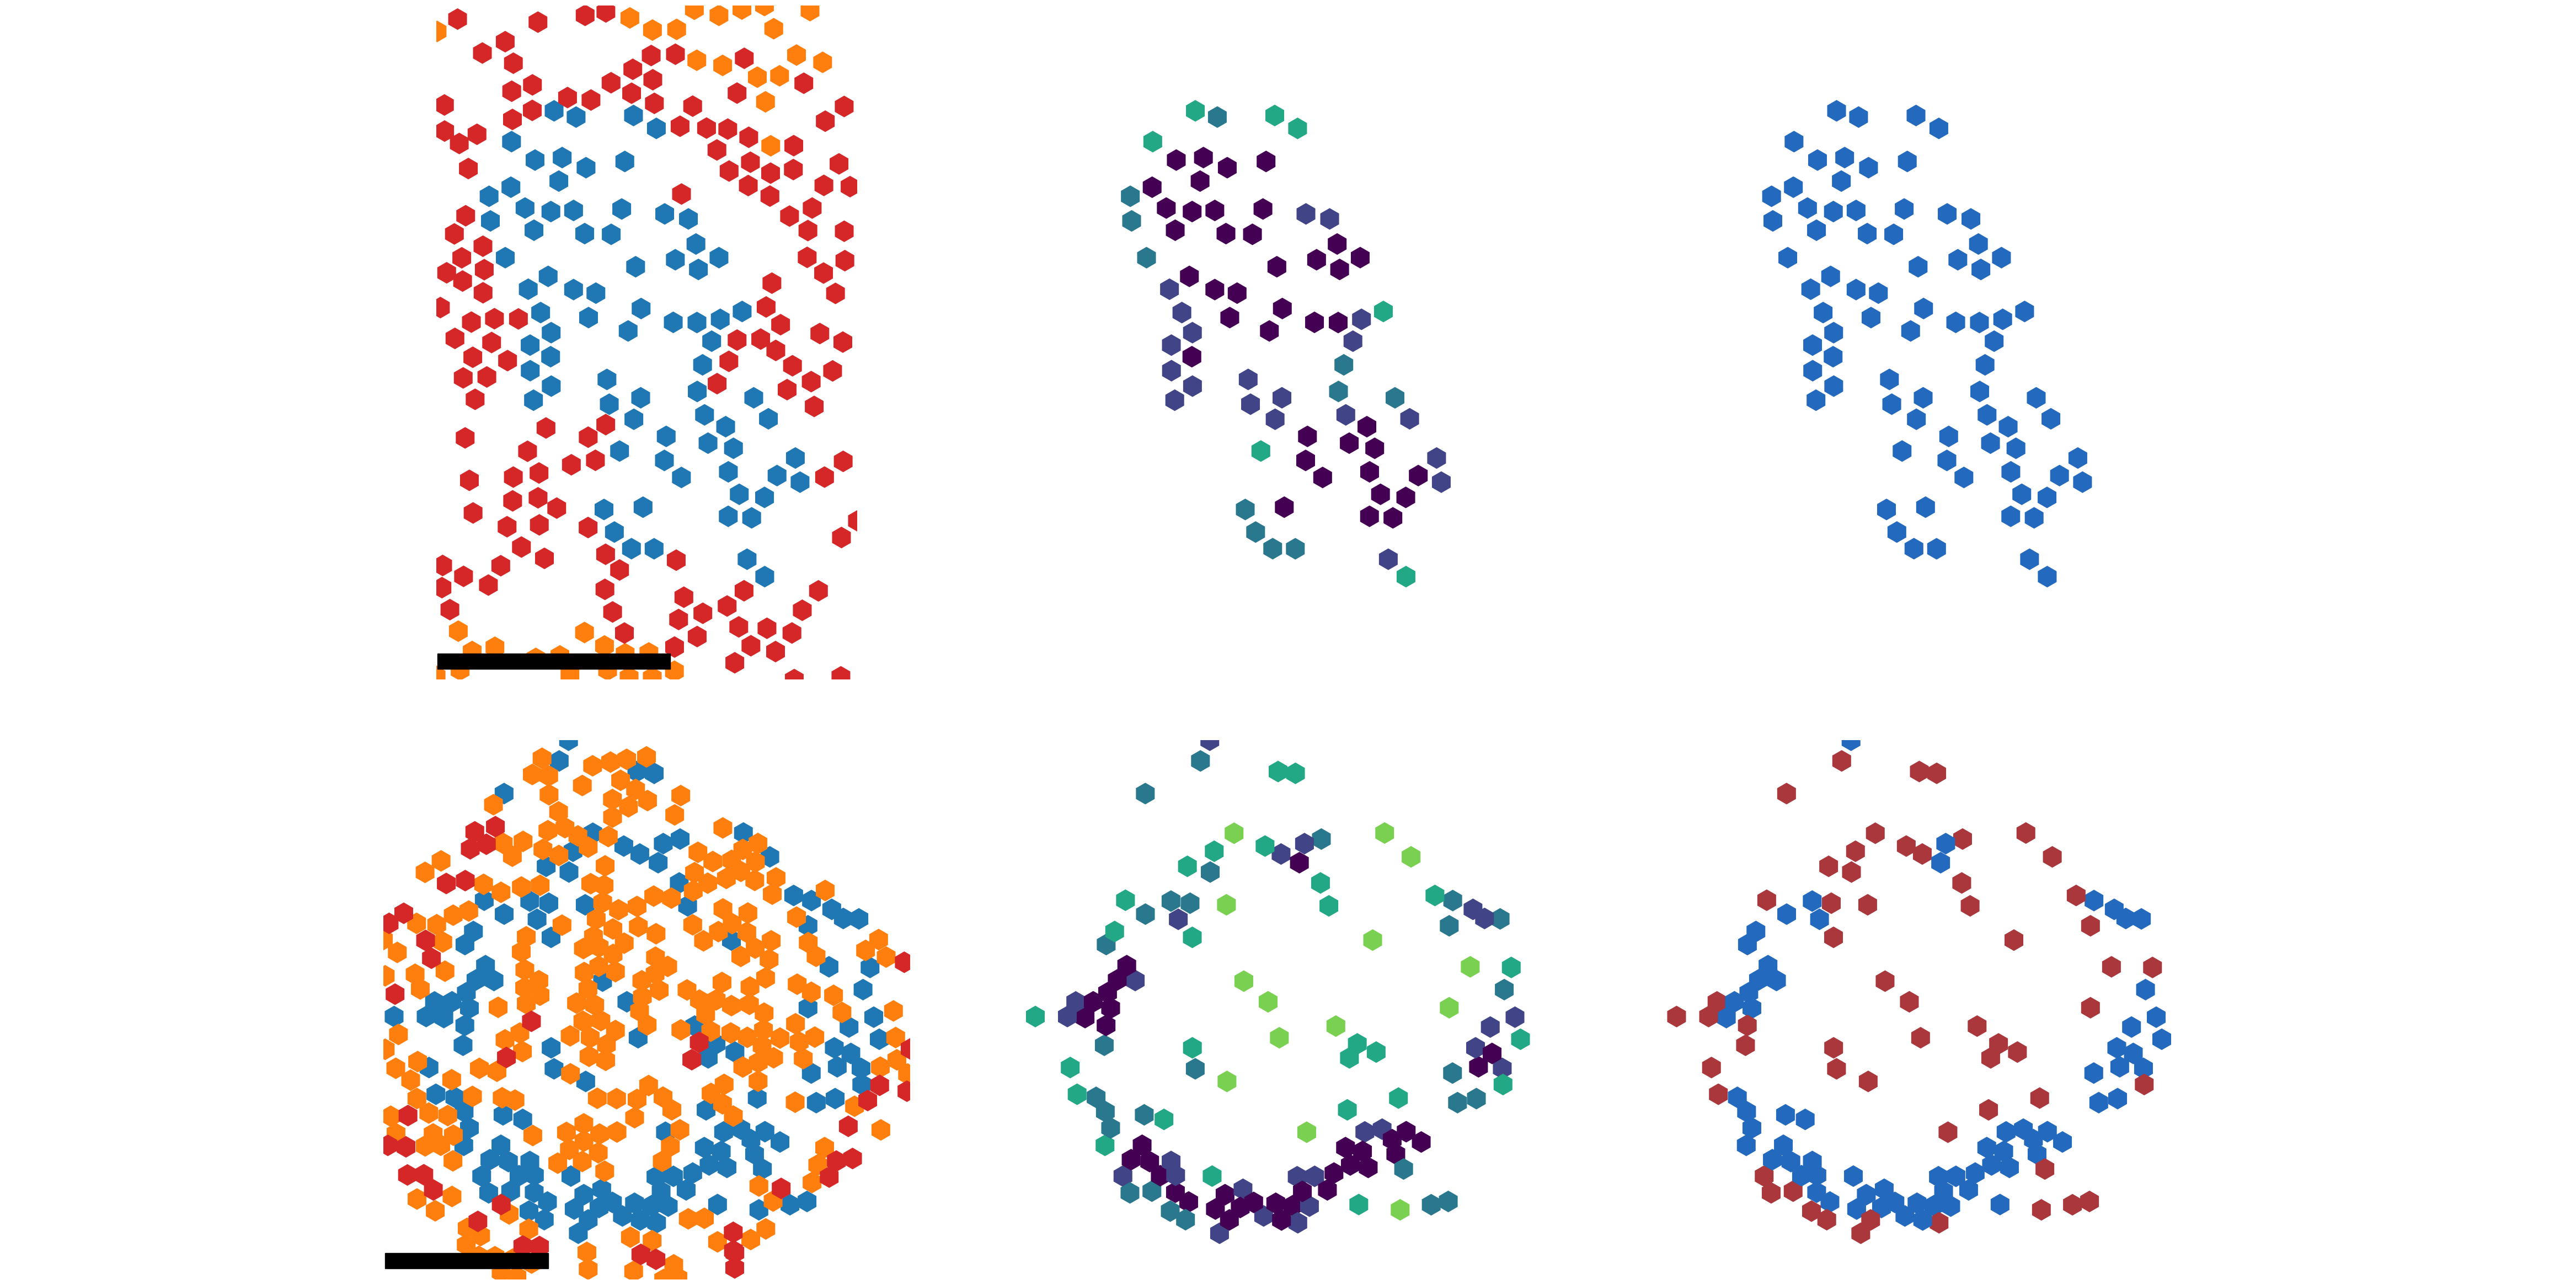

In [14]:
fig, axes = plt.subplots(figsize=(60, 30))
axes.set_axis_off()
gs = gridspec.GridSpec(2, 3, height_ratios=[1.25, 1.0])

from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

# plt.tight_layout() 
##### Organized Tubule #####

## Run distillation on each test fold separately and plot distillation scores


for kfold in range(1,2):

    # print(f'Kfold {kfold}')
    
    ## spatial split
    train_anndata = adata_es[adata_es.obs[f'train_test_fold_{kfold}'] == 0]
    test_anndata = adata_es[adata_es.obs[f'train_test_fold_{kfold}'] == 1]
    
    
    ## balance after train/test split b/c of spatial partitioning
    train_anndata = balance_anndata(train_anndata, 'classify_condition')


    classifier = RidgeClassifierCV(alphas=[1000, 2500, 5000.0])
    classifier.fit(train_anndata.obsm[feature_key], train_anndata.obs['classify_condition'])
    
    predicted_condition = classifier.predict(test_anndata.obsm[feature_key])

    test_anndata.obs['predicted_condition'] = predicted_condition
    
    test_anndata.obs['es_purity'] = test_anndata.obsm['ncv_k5'][:,0]

    s = 800.0
    
    for i in range(1,2):
        
        xlim = (3700, 3980)
        ylim = (4400, 4850)
        
        genes = ["Smcp"]
        

        test_anndata_sample = test_anndata[test_anndata.obs['sample_id'] == i]
        test_anndata_sample_es = test_anndata_sample[test_anndata_sample.obs['cell_type'] == 'ES']
        
        sc.pp.normalize_total(test_anndata_sample_es)
        sc.pp.log1p(test_anndata_sample_es)

        test_anndata_all_ctypes = adata[adata.obs[f'train_test_fold_{kfold}'] == 1]
        
        test_anndata_sample_all_ctypes = test_anndata_all_ctypes[test_anndata_all_ctypes.obs['sample_id'] == i]
        
        keep_inds = np.array(test_anndata_sample_all_ctypes.obs["y"] > xlim[0]) & np.array(test_anndata_sample_all_ctypes.obs["y"] < xlim[1]) & np.array( test_anndata_sample_all_ctypes.obs["x"] > ylim[0]) & np.array(test_anndata_sample_all_ctypes.obs["x"] < ylim[1]) 
        
        test_anndata_sample_all_ctypes = test_anndata_sample_all_ctypes[keep_inds]
        
        x_lim_all_ctypes = (np.min(test_anndata_sample_all_ctypes.obs['x']), np.max(test_anndata_sample_all_ctypes.obs['x']))
        y_lim_all_ctypes = (np.min(test_anndata_sample_all_ctypes.obs['y']), np.max(test_anndata_sample_all_ctypes.obs['y']))
        ax1 = fig.add_subplot(gs[0, 0])
        scatter(test_anndata_sample_all_ctypes, 'cell_type', mode="categorical", x_key="y", y_key="x", s = s,cdict=cdict,ax=ax1, show_legend=False)
        scalebar = AnchoredSizeBar(ax1.transData,
                                   153.85, '', 'lower left', 
                                   pad=0.1,
                                   color='black',
                                   frameon=False,
                                   size_vertical=10)
        ax1.add_artist(scalebar)
        
        keep_inds = np.array(test_anndata_sample.obs["y"] > xlim[0]) & np.array(test_anndata_sample.obs["y"] < xlim[1]) & np.array( test_anndata_sample.obs["x"] > ylim[0]) & np.array(test_anndata_sample.obs["x"] < ylim[1]) 
        
        test_anndata_sample_es = test_anndata_sample_es[keep_inds]

        ax2 = fig.add_subplot(gs[0,1])
        scatter(test_anndata_sample_es, 'es_purity', mode='continuous', x_key="y", y_key="x", s = s,fig=fig,ax=ax2,colorbar_label='ES Purity', show_colorbar=False, colorbar_labelpad=labelpad*2,cmap='viridis_r',vmin=0.0,vmax=1.0, x_lim=y_lim_all_ctypes, y_lim=x_lim_all_ctypes, legend_fontsize=tickfontsize, colorbar_fontsize=tickfontsize)
        test_anndata_sample.obs['cell_type'] = test_anndata_sample.obsm['cell_type_proportions'].idxmax(axis=1)

        
        ax3 = fig.add_subplot(gs[0, 2])
        scatter(test_anndata_sample_es, 'predicted_condition', x_key="y", y_key="x", s = s,fig=fig,ax=ax3,vmin=0,vmax=1, cmap='vlag', colorbar_label='Diabetes Score', colorbar_labelpad=labelpad*2, x_lim=y_lim_all_ctypes, y_lim=x_lim_all_ctypes, legend_fontsize=tickfontsize, show_colorbar = False, colorbar_fontsize=tickfontsize)



###### disorganized tubule ####



## Run distillation on each test fold separately and plot distillation scores

for kfold in range(3,4):

    # print(f'Kfold {kfold}')
    
    ## spatial split
    train_anndata = adata_es[adata_es.obs[f'train_test_fold_{kfold}'] == 0]
    test_anndata = adata_es[adata_es.obs[f'train_test_fold_{kfold}'] == 1]
    
    
    ## balance after train/test split b/c of spatial partitioning
    train_anndata = balance_anndata(train_anndata, 'classify_condition')


    classifier = RidgeClassifierCV(alphas=[5000.0])
    classifier.fit(train_anndata.obsm[feature_key], train_anndata.obs['classify_condition'])
    
    predicted_condition = classifier.predict(test_anndata.obsm[feature_key])

    test_anndata.obs['predicted_condition'] = predicted_condition
    
    test_anndata.obs['es_purity'] = test_anndata.obsm['ncv_k5'][:,0]

    # s = 300.0
    
    for i in range(5,6):
        
        xlim = (4150,4650)
        ylim = (990,1700)
        
        test_anndata_sample = test_anndata[test_anndata.obs['sample_id'] == i]


        ## plot all ctypes
        
        test_anndata_all_ctypes = adata[adata.obs[f'train_test_fold_{kfold}'] == 1]
        
        test_anndata_sample_all_ctypes = test_anndata_all_ctypes[test_anndata_all_ctypes.obs['sample_id'] == i]
        
        keep_inds = np.array(test_anndata_sample_all_ctypes.obs["y"] > xlim[0]) & np.array(test_anndata_sample_all_ctypes.obs["y"] < xlim[1]) & np.array( test_anndata_sample_all_ctypes.obs["x"] > ylim[0]) & np.array(test_anndata_sample_all_ctypes.obs["x"] < ylim[1]) 
        
        test_anndata_sample_all_ctypes = test_anndata_sample_all_ctypes[keep_inds]
        
        ## diagonal lines to remove other 2 tubules in frame
        remove_inds = np.array(test_anndata_sample_all_ctypes.obs["x"] - 6175 > - test_anndata_sample_all_ctypes.obs["y"]) #& np.array(test_anndata_sample_all_ctypes.obs["y"] > 4500)
        test_anndata_sample_all_ctypes = test_anndata_sample_all_ctypes[~remove_inds]

        remove_inds = np.array(test_anndata_sample_all_ctypes.obs["x"] - 5500 < - test_anndata_sample_all_ctypes.obs["y"]) #& (np.array(test_anndata_sample_all_ctypes.obs["y"]) < 4200)
        test_anndata_sample_all_ctypes = test_anndata_sample_all_ctypes[~remove_inds]

        remove_inds = np.array(test_anndata_sample_all_ctypes.obs["y"] - 2550 < test_anndata_sample_all_ctypes.obs["x"]) #& (np.array(test_anndata_sample_all_ctypes.obs["y"]) < 4200)
        test_anndata_sample_all_ctypes = test_anndata_sample_all_ctypes[~remove_inds]

        ax4 = fig.add_subplot(gs[1, 0])
        scatter(test_anndata_sample_all_ctypes, 'cell_type', mode="categorical", x_key="y", y_key="x", s = s,cdict=cdict,ax=ax4, show_legend=False)
        scalebar = AnchoredSizeBar(ax4.transData,
                                   153.85, '', 'lower left', 
                                   pad=0.1,
                                   color='black',
                                   frameon=False,
                                   size_vertical=15)
        ax4.add_artist(scalebar)

        y_lim_all_ctypes = (np.min(test_anndata_sample_all_ctypes.obs['x']), np.max(test_anndata_sample_all_ctypes.obs['x']))
        x_lim_all_ctypes = (np.min(test_anndata_sample_all_ctypes.obs['y']), np.max(test_anndata_sample_all_ctypes.obs['y']))
        

        ## plot ES cells
        test_anndata_sample_es = test_anndata_sample[test_anndata_sample.obs['cell_type'] == 'ES']
        
        keep_inds = np.array(test_anndata_sample_es.obs["y"] > xlim[0]) & np.array(test_anndata_sample_es.obs["y"] < xlim[1]) & np.array( test_anndata_sample_es.obs["x"] > ylim[0]) & np.array(test_anndata_sample_es.obs["x"] < ylim[1]) 
        
        
        test_anndata_sample_es = test_anndata_sample_es[keep_inds]

        ## diagonal lines to remove other 2 tubules in frame
        remove_inds = np.array(test_anndata_sample_es.obs["x"] - 6175 > - test_anndata_sample_es.obs["y"]) #& np.array(test_anndata_sample_all_ctypes.obs["y"] > 4500)
        test_anndata_sample_es = test_anndata_sample_es[~remove_inds]

        remove_inds = np.array(test_anndata_sample_es.obs["x"] - 5500 < - test_anndata_sample_es.obs["y"]) #& (np.array(test_anndata_sample_all_ctypes.obs["y"]) < 4200)
        test_anndata_sample_es = test_anndata_sample_es[~remove_inds]

        remove_inds = np.array(test_anndata_sample_es.obs["y"] - 2550 < test_anndata_sample_es.obs["x"]) #& (np.array(test_anndata_sample_all_ctypes.obs["y"]) < 4200)
        test_anndata_sample_es = test_anndata_sample_es[~remove_inds]

        ax5 = fig.add_subplot(gs[1, 1])
        scatter(test_anndata_sample_es, 'es_purity', mode='continuous', x_key="y", y_key="x", s = s,fig=fig,ax=ax5,cmap='viridis_r',colorbar_label='ES Purity', show_colorbar=False, colorbar_labelpad=labelpad*2,vmin=0.0,vmax=1.0, x_lim = x_lim_all_ctypes, y_lim=y_lim_all_ctypes, legend_fontsize=tickfontsize, colorbar_fontsize=tickfontsize)
        
        test_anndata_sample.obs['cell_type'] = test_anndata_sample.obsm['cell_type_proportions'].idxmax(axis=1)

        ax6 = fig.add_subplot(gs[1, 2])
        scatter(test_anndata_sample_es, 'predicted_condition', x_key="y", y_key="x", s = s,fig=fig,ax=ax6,vmin=0,vmax=1, cmap='vlag', colorbar_label='Diabetes Score', colorbar_labelpad=labelpad*2, x_lim = x_lim_all_ctypes, y_lim=y_lim_all_ctypes, legend_fontsize=tickfontsize, show_colorbar = False, colorbar_fontsize=tickfontsize, cbar_ticks=[0.0, 0.5, 1.0])
        
       
plt.subplots_adjust(wspace=-0.5, hspace=0.1)
plt.savefig('./plots/fig_2f.pdf', transparent=True, dpi=600, bbox_inches='tight')
        


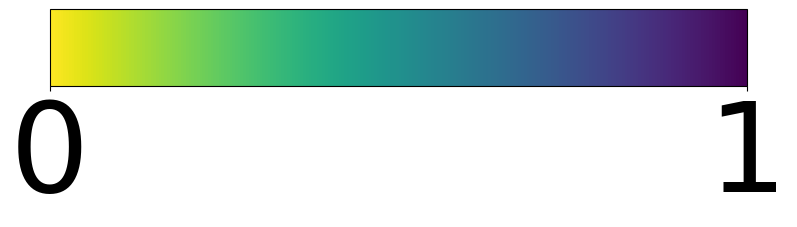

In [15]:
fig, cbar_ax = plt.subplots(figsize=(9,1))
norm = plt.Normalize(vmin=0.0, vmax=1.0)
sm = plt.cm.ScalarMappable(cmap='viridis_r', norm=norm)
cbar = plt.colorbar(sm, cax=cbar_ax, orientation='horizontal')
cbar_ax.tick_params(labelsize=tickfontsize)
cbar_ax.set_xticks([0, 1])
fig.savefig('./plots/fig_2f_colorbar1.pdf', transparent=True, bbox_inches='tight',dpi=600)

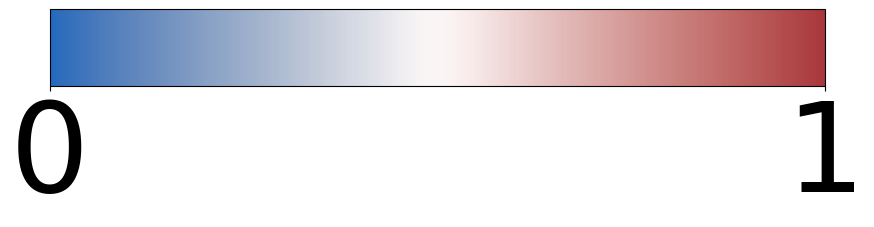

In [16]:
fig, cbar_ax = plt.subplots(figsize=(10,1))
norm = plt.Normalize(vmin=0.0, vmax=1.0)
sm = plt.cm.ScalarMappable(cmap='vlag', norm=norm)
cbar = plt.colorbar(sm, cax=cbar_ax, orientation='horizontal')
cbar_ax.tick_params(labelsize=tickfontsize)
cbar_ax.set_xticks([0, 1])
fig.savefig('./plots/fig_2f_colorbar2.pdf', transparent=True, bbox_inches='tight',dpi=600)

### Generate 2E

In [17]:
import warnings
warnings.filterwarnings('ignore')

import sklearn

# for k in [5,10,25,50,100,500]:
for k in [5]:
    ## es purity

    predicted_wt_es_purity = []
    predicted_db_es_purity = []

    wt_es_purity = []
    db_es_purity = []

    for kfold in range(1,5):

        print(f"Running kfold {kfold}")
        
        ## spatial split
        train_anndata = adata_es[adata_es.obs[f'train_test_fold_{kfold}'] == 0]
        test_anndata = adata_es[adata_es.obs[f'train_test_fold_{kfold}'] == 1]

        ## balance after train/test split b/c of spatial partitioning
        print("Train data")
        train_anndata = balance_anndata(train_anndata, 'classify_condition')
        
        
        classifier = RidgeClassifierCV(alphas=[1000.0])
        classifier.fit(train_anndata.obsm[feature_key], train_anndata.obs['classify_condition'])

        print(classifier.alpha_)

        print("Fit alpha:")
        print(classifier.alpha_)

        print("Train score:")
        print(classifier.score(train_anndata.obsm[feature_key], train_anndata.obs['classify_condition']))

        print("Test score:")
        print(classifier.score(test_anndata.obsm[feature_key], test_anndata.obs['classify_condition']))
        predicted_condition = classifier.decision_function(test_anndata.obsm[feature_key])

        test_anndata.obs['predicted_condition'] = predicted_condition

        cell_type = test_anndata.obs['cell_type']


        ncv_k = test_anndata.obsm[f'ncv_k{k}']
        es_purity = ncv_k[cell_type == "ES",0]


        es_predicted_condition = predicted_condition[cell_type == "ES"]

        es_condition = test_anndata.obs['classify_condition'][cell_type == "ES"]
        
        thresh = 0.0
        ## only distill diabetic samples
        if test_anndata.obs['classify_condition'][0] == 1:
            es_predicted_disease_inds = np.where(es_predicted_condition > thresh)[0]
            es_predicted_wt_inds = np.where(es_predicted_condition <= thresh)[0]
        else:
            es_predicted_disease_inds = np.where(es_predicted_condition > thresh)[0]
            es_predicted_wt_inds = np.where(es_predicted_condition <= thresh)[0]

        es_disease_inds = np.where(es_condition == 1)[0]
        es_wt_inds = np.where(es_condition == 0)[0]


        predicted_wt_es_purity.append(es_purity[es_predicted_wt_inds])
        predicted_db_es_purity.append(es_purity[es_predicted_disease_inds])

        wt_es_purity.append(es_purity[es_wt_inds])
        db_es_purity.append(es_purity[es_disease_inds])


    mean_predicted_wt_es_purity = []
    mean_predicted_db_es_purity = []

    mean_wt_es_purity = []
    mean_db_es_purity = []

    for i in range(4):

        mean_predicted_wt_es_purity.append(np.mean(predicted_wt_es_purity[i]))
        mean_predicted_db_es_purity.append(np.mean(predicted_db_es_purity[i]))

        mean_wt_es_purity.append(np.mean(wt_es_purity[i]))
        mean_db_es_purity.append(np.mean(db_es_purity[i]))
        
    all_folds_predicted_wt_es_purity = np.concatenate(predicted_wt_es_purity, axis=0)
    all_folds_predicted_db_es_purity = np.concatenate(predicted_db_es_purity, axis=0)

    all_folds_wt_es_purity = np.concatenate(wt_es_purity, axis=0)
    all_folds_db_es_purity = np.concatenate(db_es_purity, axis=0)

Running kfold 1
Train data
1000.0
Fit alpha:
1000.0
Train score:
0.6106428481570009
Test score:
0.535237759360489
Running kfold 2
Train data
1000.0
Fit alpha:
1000.0
Train score:
0.5940684350342968
Test score:
0.6024052478134111
Running kfold 3
Train data
1000.0
Fit alpha:
1000.0
Train score:
0.5931674416656194
Test score:
0.5824255628177197
Running kfold 4
Train data
1000.0
Fit alpha:
1000.0
Train score:
0.6022224976246541
Test score:
0.5724181360201511


In [18]:
## plotting parameters

linewidth = 5
tickfontsize = 150
labelfontsize = 150
labelpad = 50
titlefontsize=150
legendfontsize=150

In [20]:
es_purity_data = pd.DataFrame([mean_wt_es_purity, mean_predicted_wt_es_purity, mean_db_es_purity, mean_predicted_db_es_purity]).T
es_purity_data.columns = ['Wild-type', 'Wild-type\nEnriched', 'Diabetes', 'Diabetes\nEnriched']

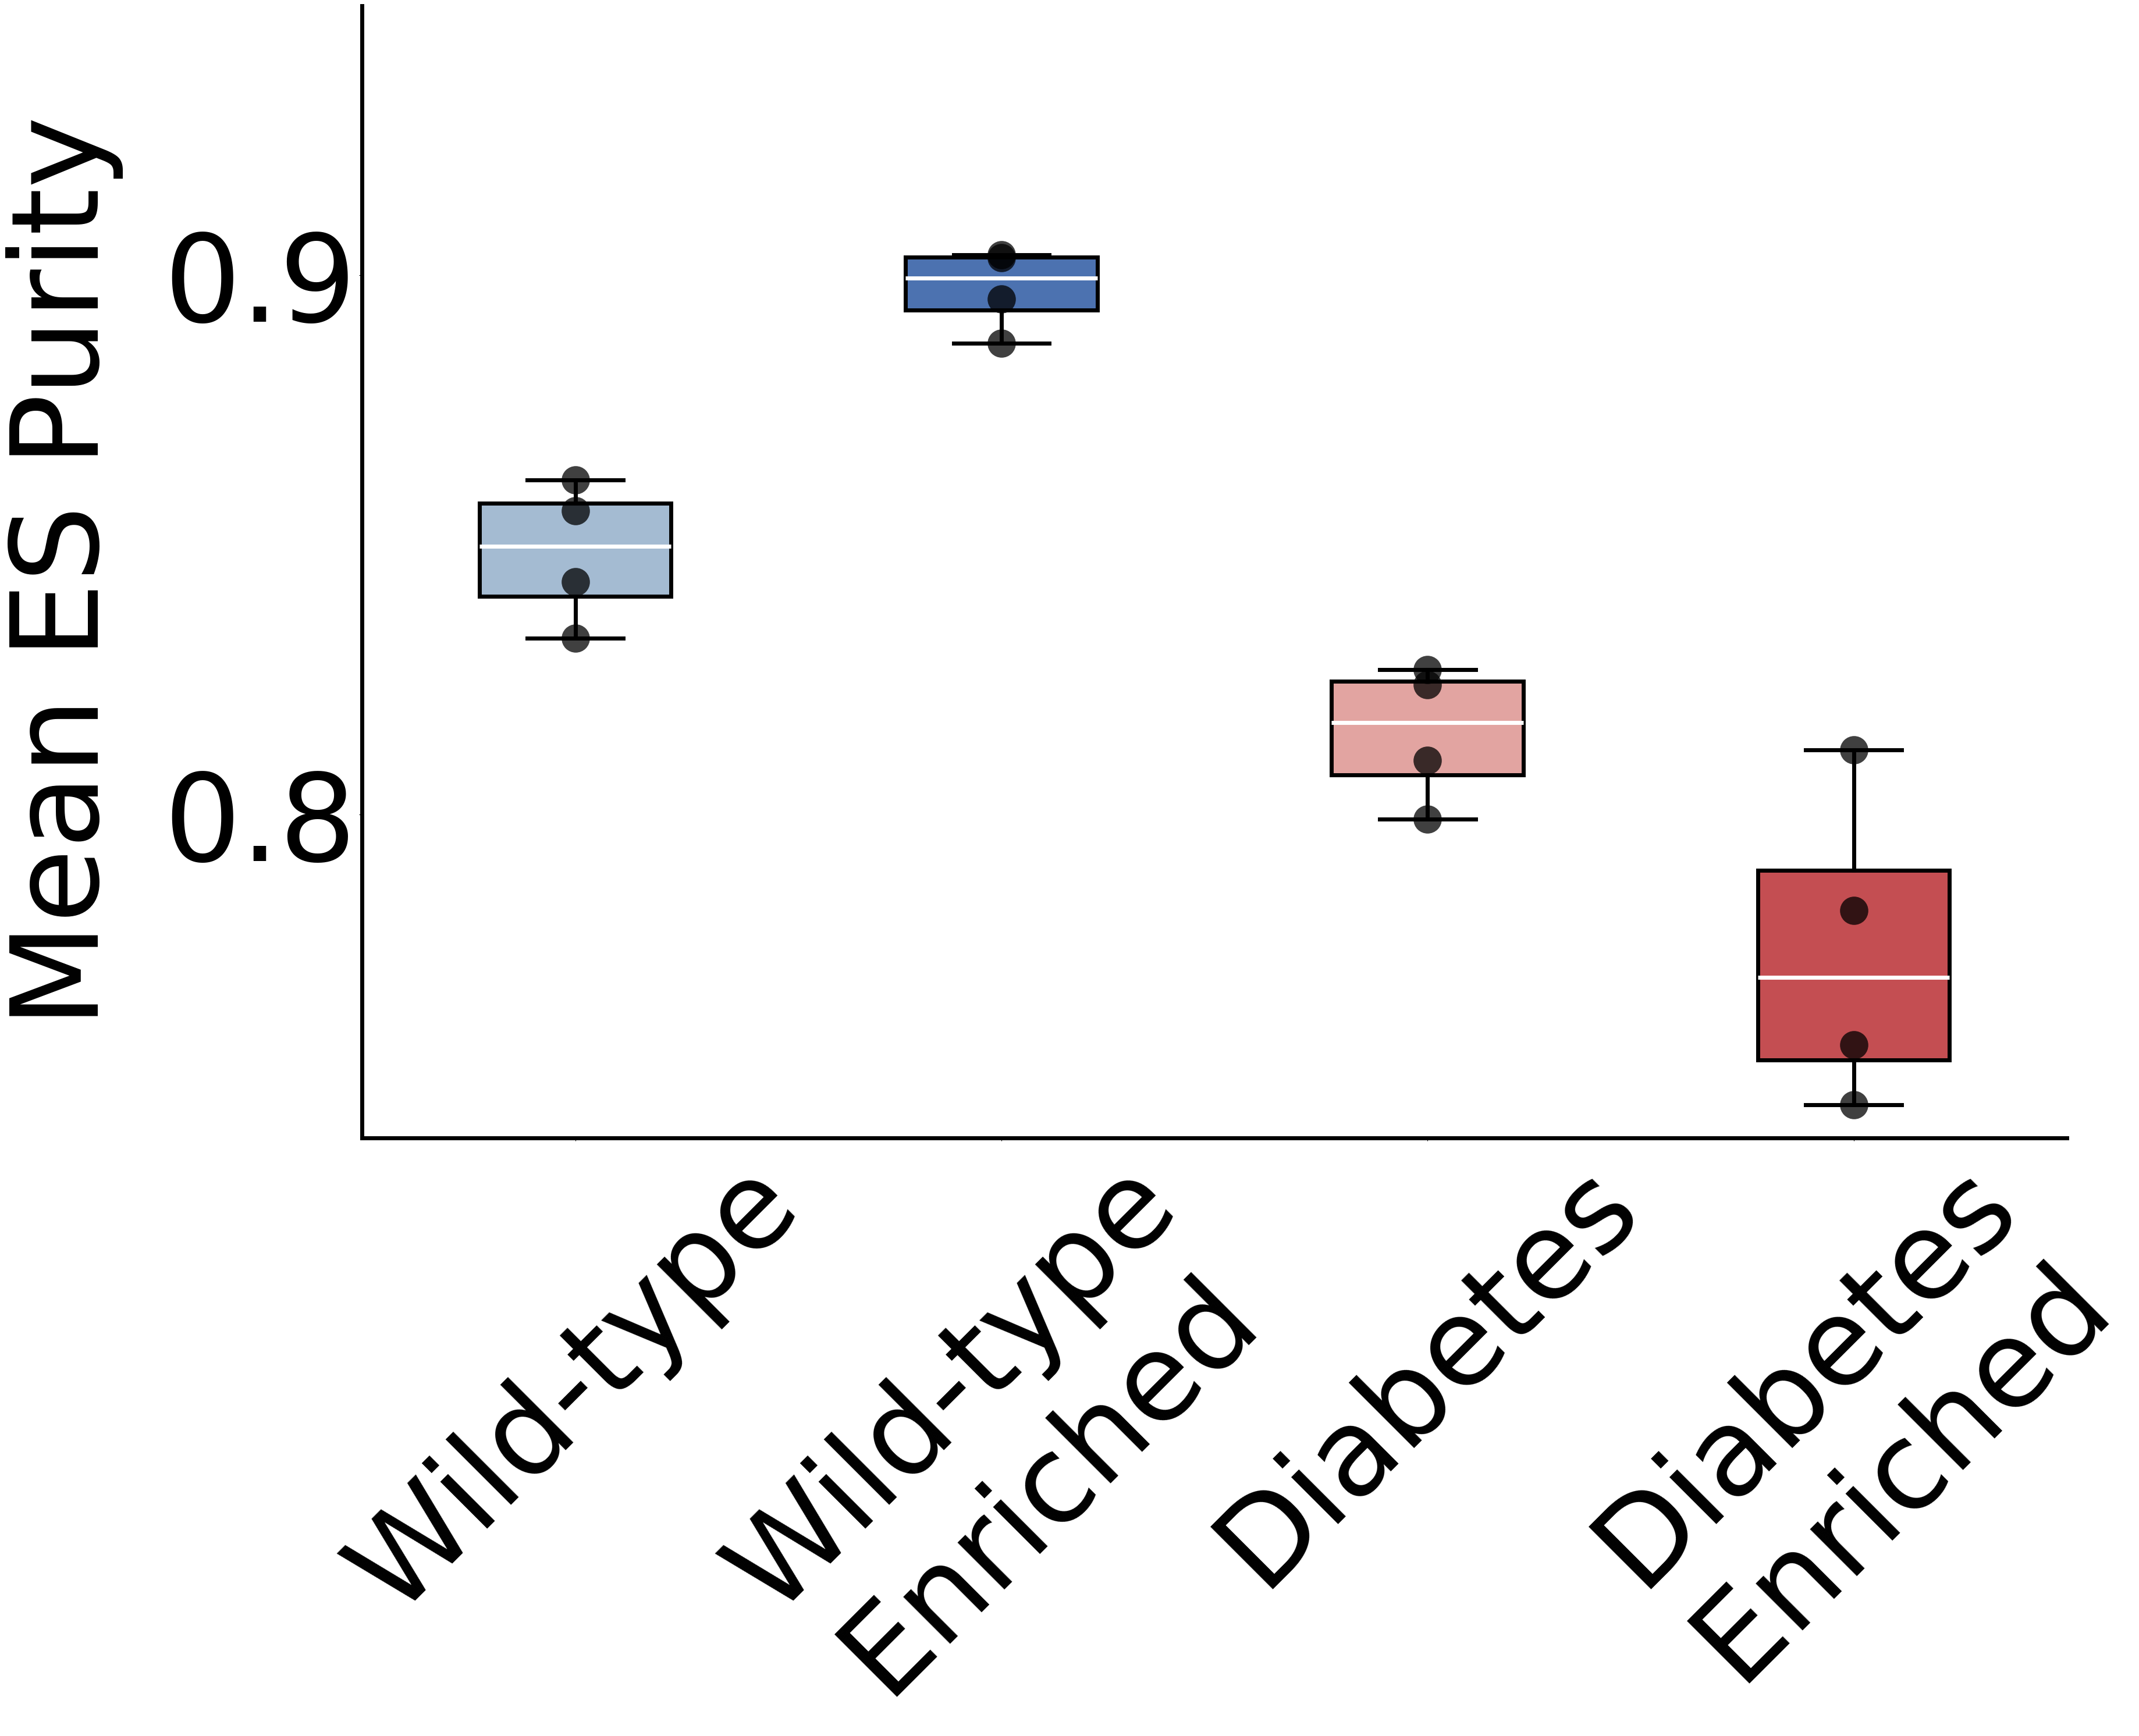

In [32]:
fig, ax = plt.subplots(figsize=(30,20))
boxplot = plt.boxplot([mean_wt_es_purity, mean_predicted_wt_es_purity, mean_db_es_purity, mean_predicted_db_es_purity], patch_artist=True, 
                 boxprops={'linewidth': linewidth},
                 whiskerprops={'linewidth': linewidth},
                 capprops={'linewidth': linewidth},
                 medianprops={'linewidth': linewidth, 'color': 'white'},
                 positions=[0,1,2,3])

es_purity_data = pd.DataFrame([mean_wt_es_purity, mean_predicted_wt_es_purity, mean_db_es_purity, mean_predicted_db_es_purity]).T
es_purity_data.columns = ['Wild-type', 'Wild-type\nEnriched', 'Diabetes', 'Diabetes\nEnriched']

sns.stripplot(data=es_purity_data, ax=ax, jitter=0, color='black', size=35, alpha=0.75)


    
colors = sns.color_palette("deep", 10).as_hex()
colors = ["#A4BBD2", colors[0], "#E2A4A1", colors[3]]

for patch, color in zip(boxplot['boxes'], colors):
    patch.set_facecolor(color)

plt.tight_layout()
plt.xticks([0,1,2,3],['Wild-type', 'Wild-type\nEnriched', 'Diabetes', 'Diabetes\nEnriched'], rotation=45)
plt.ylabel('Mean ES Purity', fontsize=labelfontsize, labelpad=labelpad)
ax.tick_params(axis='both', labelsize=tickfontsize)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(linewidth)
ax.spines['left'].set_linewidth(linewidth)
ax.set_yticks([0.8, 0.9])
plt.ylim(0.74, 0.95)
# plt.tight_layout()
plt.savefig('./plots/fig_2e.pdf', transparent=True, dpi=600, bbox_inches='tight')